In [36]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords
import csv
import io
import spacy
import numpy as np

In [37]:
%matplotlib inline

In [38]:
#Pour Sophie
def creation_csv(nom_livre,numero_livre):
    chemin = r"C:\Users\Sophie\Harry-Python\Data\Book " + numero_livre + " - " + nom_livre + ".txt"
    sortie = r"C:\Users\Sophie\Harry-Python\Data\book" + numero_livre + ".csv"
    with io.open(chemin,"r",encoding="utf-8") as infile, open(sortie, 'w',encoding = 'utf-8-sig') as outfile:
        stripped = (line.strip() for line in infile)
        lines = (line.split(",") for line in stripped if line)
        writer = csv.writer(outfile)
        writer.writerows(lines)

In [39]:
#On crée un dictionnaire
Books = {'The Philosophers Stone': '1',
        'The Chamber of Secrets': '2',
        'The Prisoner of Azkaban': '3',
        'The Goblet of Fire':'4',
        'The Order of the Phoenix': '5',
        'The Half Blood Prince': '6',
        'The Deathly Hallows': '7'}

In [40]:
#Pour Sophie
#On fait une boucle exécutant la fonction sur chaque élément du dictionnaire
Books_csv = {}
for title, i in Books.items():
    creation_csv(title, i)
    Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)

<ipython-input-40-1664f9427c7a>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)


In [41]:
# Créer un tableau avec tous les livres
df_books = pd.DataFrame(Books_csv.items(), columns = ['Books', 'Text'])
df_books

,Books,Text
0,book1,...
1,book2,...
2,book3,...
3,book4,...
4,book5,...
5,book6,...
6,book7,...


In [42]:
#On veut éliminer le numéro de page hyper relou
import re
pattern = ["Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Philosophers Stone[\s]?-[\s]?J.K. Rowling",
           "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Chamber of Secrets[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Prisoner of Azkaban[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Goblet of Fire[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[l0-9]?[lOU0-9]?[lOU0-9]?[lOU0-9][\s]?Harry Potter and the Order of the Phoenix[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Half Blood Prince[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Deathly Hallows[\s]?-[\s]?J.K. Rowling"]

In [43]:
def clean_page(text, pattern):
    for ele in pattern:
        liste_regex = re.findall(ele, text, re.IGNORECASE)
        for expression in liste_regex:
            text = text.replace(expression, '')
    return text

In [44]:
#Création du même dictionnaire mais avec texte fusionné pour chaque tome
all_text = Books_csv.copy()
for i in Books_csv:
    all_text[i] = ' '.join([text for text in Books_csv[i][0]])

In [45]:
#Application de la fonction au dictionnaire des livres
for i in all_text:
    all_text[i] = clean_page(all_text[i], pattern)

In [47]:
#nltk.download('punkt')
all_text_clean = all_text.copy()

for i in all_text:
    
    text_list = nltk.tokenize.word_tokenize(all_text[i])
    text_list = [x.lower() for x in text_list]
    text_clean = [w.lower() for w in text_list if w not in stopwords and w.isalpha()]
    text_clean = ' '.join(text.lower() for text in text_clean)
    all_text_clean[i] = text_clean

In [56]:
type(all_text)

dict

In [25]:
#!pip install Helpers

In [30]:
!pip install vaderSentiment

In [31]:
sentences = [
    "Our Saturday classes and fun and super interesting!",
    "Make sure you :) or :D today!",
    "The book was great, I enjoyed it very much.",
    "At least it isn't a horrible book.",
    "I got a very bad grade on my homework.",
    "Today is a really terrible day :("
]

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# this line just creates a sentiment model
sentiment_model = SentimentIntensityAnalyzer()

# now we will iterate over all sentences and get their sentiment
for sentence in sentences:
    
    # get sentiment
    scores = sentiment_model.polarity_scores(sentence)
    
    # print the sentence and sentiment
    print(sentence)
    
    # the {: <15} characters just tell python to add spaces between columns
    print("negative: {: <15} neutral: {: <15} positive: {: <15} compound: {}\n".format(
        scores['neg'], scores['neu'], scores['pos'], scores['compound']
    ))

Our Saturday classes and fun and super interesting!
negative: 0.0             neutral: 0.329           positive: 0.671           compound: 0.8805

Make sure you :) or :D today!
negative: 0.0             neutral: 0.294           positive: 0.706           compound: 0.8633

The book was great, I enjoyed it very much.
negative: 0.0             neutral: 0.486           positive: 0.514           compound: 0.8126

At least it isn't a horrible book.
negative: 0.0             neutral: 0.678           positive: 0.322           compound: 0.431

I got a very bad grade on my homework.
negative: 0.322           neutral: 0.678           positive: 0.0             compound: -0.5849

Today is a really terrible day :(
negative: 0.567           neutral: 0.433           positive: 0.0             compound: -0.762



In [60]:
sentences = nltk.word_tokenize(all_text_clean['book1'])

In [33]:
#import helpers
#from helpers.load_data import *
#from helpers.plot_data import *
#from collections import Counter
#import nltk
#nltk.download('punkt')

In [62]:
for sentence in sentences[0:500]:
    
    scores = sentiment_model.polarity_scores(sentence)
    
    print(sentence)
    
    print("negative: {: <15} neutral: {: <15} positive: {: <15} compound: {}\n".format(
        scores['neg'], scores['neu'], scores['pos'], scores['compound']
    ))

boy
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

lived
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

dursley
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

number
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.0772

four
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

privet
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

drive
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

proud
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.4767

say
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

perfectly
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.6369

normal
n


home
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

number
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.0772

changed
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

mind
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

put
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

receiver
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

back
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

stroked
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

mustache
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

thinking
negative: 0.0             neutral: 1.0             positive: 0.0             compound: 0.0

stupid


In [99]:
all_scores = []

for sentence in sentences:
    
    scores = sentiment_model.polarity_scores(sentence)
    
    all_scores.append([sentence, scores])

In [101]:
type(scores)

dict

In [64]:
sorted_sentences = sorted(all_scores, key=lambda x: x[1]['pos'], reverse=True)[:10]

for sentence, scores in sorted_sentences:

    print(sentence)
    
    print("negative: {: <15} neutral: {: <15} positive: {: <15} compound: {}\n".format(
        scores['neg'], scores['neu'], scores['pos'], scores['compound']
    ))

number
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.0772

proud
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.4767

perfectly
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.6369

thank
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.3612

useful
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.4404

greatest
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.6369

good
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.4404

want
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.0772

like
negative: 0.0             neutral: 0.0             positive: 1.0             compound: 0.3612

happily
negative: 0.0             neutral: 0.0             positive: 1.0             

In [92]:
book_scores = []
for i in all_text_clean:

    words = nltk.word_tokenize(all_text_clean[str(i)])

            # to calculate average score, we will first store scores for all sentences
    all_scores = []    
    for word in words:
        scores = sentiment_model.polarity_scores(word)
        compound_score = scores['compound']
        all_scores.append(compound_score)

        # average is calculated as sum of all scores divided by number of scores
    book_score = sum(all_scores) / len(all_scores)
    book_scores.append(book_score)

In [93]:
print(book_scores)

[0.005374916733952407, 0.0030386115115892047, 0.003553512159850472, 0.0044260720376837455, 0.0038894091718745046, 0.0067082858604412664, -0.000797572314567129]


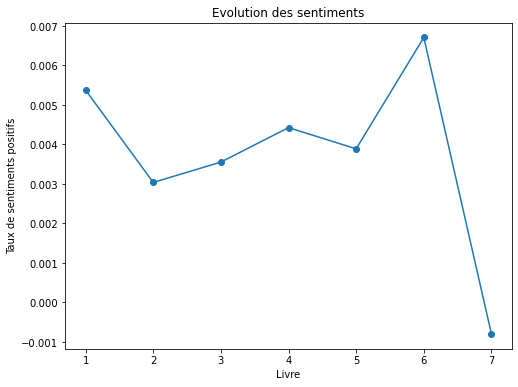

In [97]:
x = np.linspace(1,7,7)
plt.figure(figsize=(8,6))
plt.plot(x, book_scores, marker = 'o', label = 'Positivité des sentiments')
plt.title('Evolution des sentiments')
plt.xlabel('Livre')
plt.ylabel('Taux de sentiments positifs')
plt.show()

In [102]:
book_scores_pos = []
book_scores_neg = []
for i in all_text_clean:

    words = nltk.word_tokenize(all_text_clean[str(i)])

    all_scores_pos = []
    all_scores_neg = []
    
    for word in words:
        scores = sentiment_model.polarity_scores(word)
        for i in scores:
            if scores[i] < 0:
                compound_score = scores['compound']
                all_scores.append(compound_score)

            # average is calculated as sum of all scores divided by number of scores
                book_score = sum(all_scores) / len(all_scores)
                book_scores_pos.append(book_score)

            if scores[i] > 0:
                compound_score = scores['compound']
                all_scores.append(compound_score)

            # average is calculated as sum of all scores divided by number of scores
                book_score = sum(all_scores) / len(all_scores)
                book_scores_neg.append(book_score)

TypeError: unsupported operand type(s) for +: 'int' and 'list'